# Insurance Cost Prediction using Linear Regression

In [219]:
import torch
import torchvision
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torch.utils.data import DataLoader, TensorDataset, random_split

## Step 1: Download and explore the data

Let us begin by downloading the data. We'll use the `download_url` function from PyTorch to get the data as a CSV (comma-separated values) file.

In [295]:
DATASET_URL = "https://gist.github.com/BirajCoder/5f068dfe759c1ea6bdfce9535acdb72d/raw/c84d84e3c80f93be67f6c069cbdc0195ec36acbd/insurance.csv"
DATA_FILENAME = "insurance.csv"
download_url(DATASET_URL, '.')

Using downloaded and verified file: ./insurance.csv


To load the dataset into memory, we'll use the `read_csv` function from the `pandas` library. The data will be loaded as a Pandas dataframe. See this short tutorial to learn more: https://data36.com/pandas-tutorial-1-basics-reading-data-files-dataframes-data-selection/

In [296]:
dataframe_raw = pd.read_csv(DATA_FILENAME)
dataframe_raw.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


### some basic questions about the dataset.


**Number of rows the dataset have**

In [300]:
dataframe.shape

(1271, 7)

In [301]:
num_rows = dataframe.shape[0]
print(num_rows)

1271


**Number of columns the dataset have**

In [302]:
num_cols = dataframe.shape[1]
print(num_cols)

7


**Input column from the dataset**

In [303]:
dataframe.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges'], dtype='object')

In [304]:
input_cols = ['age', 'sex', 'bmi', 'children', 'smoker']

**Non-numeric or categoriacolumns are in dataset**



In [305]:
categorical_cols = ['sex','smoker']

**Output or Target variable(s) column**

In [306]:
output_cols = ['charges']

**Minimum, maximum and average value of the charges column. Distribution of values in a graph.**

In [307]:
print('Minimum',min(dataframe['charges']))
print('Maximum',max(dataframe['charges']))
print('Average',(dataframe['charges'].mean()))

Minimum 1088.217683
Maximum 61857.3151697
Average 12914.76944657044


<ipython-input-308-14e78b178eef>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dataframe.charges);


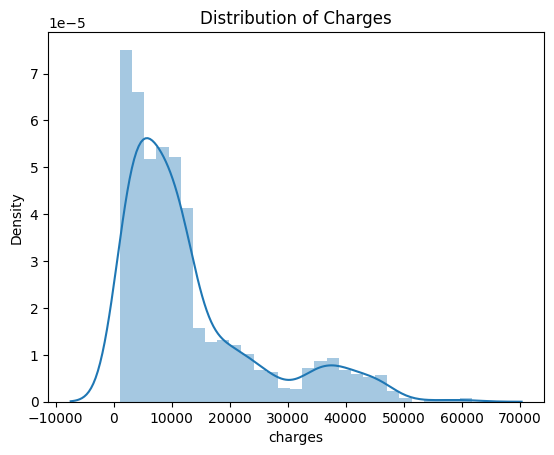

In [308]:
import seaborn as sns
plt.title("Distribution of Charges")

sns.distplot(dataframe.charges);

## Step 2: Prepare the dataset for training

We need to convert the data from the Pandas dataframe into a PyTorch tensors for training. To do this, the first step is to convert it numpy arrays. If you've filled out `input_cols`, `categorial_cols` and `output_cols` correctly, this following function will perform the conversion to numpy arrays.

In [309]:
def dataframe_to_arrays(dataframe):
  # Make a copy of the original dataframe
  dataframe1 = dataframe.copy(deep= True)
  # Convert non-numeric categorical columns to numbers
  for col in categorical_cols:
    dataframe1[col] = dataframe1[col].astype('category').cat.codes
  # Extract inputs and outputs as numpy arrays
  inputs_array = dataframe1[input_cols].to_numpy()
  targets_array = dataframe1[output_cols].to_numpy()
  return inputs_array, targets_array




In [310]:
dataframe

,age,sex,bmi,children,smoker,region,charges
27,55,female,37.69125,2,no,northwest,11900.573282
997,63,female,42.37750,0,no,southeast,13471.329445
162,54,male,45.54000,1,no,southwest,10137.035440
824,60,male,27.96800,0,no,northwest,12147.896656
392,48,male,36.16175,1,no,northeast,8695.138733
...,...,...,...,...,...,...,...
381,55,male,35.28775,0,yes,northeast,41034.581386
538,46,female,32.25750,1,no,southeast,7986.104575
73,58,male,36.81150,1,no,southeast,11588.227123
521,32,female,50.85300,0,no,southeast,3874.352466


In [311]:
inputs_array, targets_array = dataframe_to_arrays(dataframe)
inputs_array, targets_array

(array([[55.     ,  0.     , 37.69125,  2.     ,  0.     ],
        [63.     ,  0.     , 42.3775 ,  0.     ,  0.     ],
        [54.     ,  1.     , 45.54   ,  1.     ,  0.     ],
        ...,
        [58.     ,  1.     , 36.8115 ,  1.     ,  0.     ],
        [32.     ,  0.     , 50.853  ,  0.     ,  0.     ],
        [35.     ,  1.     , 20.539  ,  1.     ,  0.     ]]),
 array([[11900.5732825],
        [13471.329445 ],
        [10137.03544  ],
        ...,
        [11588.227123 ],
        [ 3874.352466 ],
        [ 4963.005388 ]]))

In [312]:
inputs_array.shape, targets_array.shape

((1271, 5), (1271, 1))

**Convert the numpy arrays `inputs_array` and `targets_array` into PyTorch tensors. with data type `torch.float32`.**

In [313]:
inputs =  torch.tensor(inputs_array, dtype=torch.float32)
targets = torch.tensor(targets_array, dtype=torch.float32)

In [314]:
inputs.dtype, targets.dtype

(torch.float32, torch.float32)

Next, we need to create PyTorch datasets & data loaders for training & validation. We'll start by creating a `TensorDataset`.

In [315]:
dataset = TensorDataset(inputs, targets)

**We will take a number between `0.1` and `0.2` to determine the fraction of data that will be used for creating the validation set. Then we will use `random_split` to create training & validation datasets.**

In [316]:
num_rows

1271

In [317]:
val_percent = 0.1 # between 0.1 and 0.2
val_size = int(num_rows * val_percent)
train_size = num_rows - val_size


train_ds, val_ds = random_split(dataset, [train_size, val_size]) # Use the random_split function to split dataset into 2 parts of the desired length

Finally, we can create data loaders for training & validation.

**Picking a batch size for the data loader.**

In [318]:
batch_size = 12

In [319]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)

Let's look at a batch of data to verify everything is working fine so far.

In [320]:
for xb, yb in train_loader:
    print("inputs:", xb)
    print("targets:", yb)
    break

inputs: tensor([[45.0000,  0.0000, 38.0650,  0.0000,  0.0000],
        [45.0000,  1.0000, 26.3293,  2.0000,  1.0000],
        [28.0000,  1.0000, 36.4320,  0.0000,  1.0000],
        [49.0000,  1.0000, 29.4400,  2.0000,  1.0000],
        [48.0000,  0.0000, 31.3547,  1.0000,  0.0000],
        [38.0000,  1.0000, 42.6075,  1.0000,  0.0000],
        [45.0000,  1.0000, 38.7550,  1.0000,  0.0000],
        [50.0000,  1.0000, 36.9265,  2.0000,  0.0000],
        [27.0000,  0.0000, 41.4920,  0.0000,  1.0000],
        [41.0000,  0.0000, 42.6650,  2.0000,  0.0000],
        [49.0000,  0.0000, 27.4217,  3.0000,  1.0000],
        [52.0000,  1.0000, 42.2050,  0.0000,  0.0000]])
targets: tensor([[ 7124.7314],
        [20465.5977],
        [33631.9844],
        [22607.3516],
        [ 9163.8330],
        [ 5897.2812],
        [ 7222.5405],
        [24573.3320],
        [36019.8828],
        [ 7150.6187],
        [23383.7051],
        [ 8870.2285]])


## Step 3: Create a Linear Regression Model



In [321]:
input_size = len(input_cols)
output_size = len(output_cols)

In [322]:
input_size, output_size

(5, 1)

In [323]:
class InsuranceModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, output_size)                  # fill this (hint: use input_size & output_size defined above)

    def forward(self, xb):
        out = self.linear(xb)                          # fill this
        return out

    def training_step(self, batch):
        inputs, targets = batch
        # Generate predictions
        out = self(inputs)
        # Calcuate loss
        #loss = F.mse_loss(out, targets)
        loss = F.smooth_l1_loss(out, targets)                           # fill this
        return loss

    def validation_step(self, batch):
        inputs, targets = batch
        # Generate predictions
        out = self(inputs)
        # Calculate loss
        #loss = F.mse_loss(out, targets)
        loss = F.smooth_l1_loss(out, targets)                            # fill this
        return {'val_loss': loss.detach()}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        return {'val_loss': epoch_loss.item()}

    def epoch_end(self, epoch, result, num_epochs):
        # Print result every 20th epoch
        if (epoch+1) % 20 == 0 or epoch == num_epochs-1:
            print("Epoch [{}], val_loss: {:.4f}".format(epoch+1, result['val_loss']))

Let us create a model using the `InsuranceModel` class. You may need to come back later and re-run the next cell to reinitialize the model, in case the loss becomes `nan` or `infinity`.

In [324]:
model = InsuranceModel()

Let's check out the weights and biases of the model using `model.parameters`.

In [325]:
list(model.parameters())

[Parameter containing:
 tensor([[-0.2595, -0.0620, -0.1902,  0.4319, -0.3940]], requires_grad=True),
 Parameter containing:
 tensor([0.1968], requires_grad=True)]

## Step 4: Train the model to fit the data

To train our model, we'll use the same `fit` function explained in the lecture. That's the benefit of defining a generic training loop - you can use it for any problem.

In [326]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result, epochs)
        history.append(result)
    return history

**Let's use the `evaluate` function to calculate the loss on the validation set before training.**

In [327]:
result = evaluate(model, val_loader) # Use the the evaluate function
print(result)

{'val_loss': 13524.2509765625}



We are now ready to train the model. You may need to run the training loop many times, for different number of epochs and with different learning rates, to get a good result. Also, if your loss becomes too large (or `nan`), you may have to re-initialize the model by running the cell `model = InsuranceModel()`. Experiment with this for a while, and try to get to as low a loss as possible.

**We will train the model 4-5 times with different learning rates & for different number of epochs.**

Will vary learning rates by orders of 10 (e.g. `1e-2`, `1e-3`, `1e-4`, `1e-5`, `1e-6`) to figure out what works.

In [328]:
epochs = 50
lr = 1e-3
history1 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 9096.6270
Epoch [40], val_loss: 7692.7144
Epoch [50], val_loss: 7498.1348


In [329]:
epochs = 300
lr = 1e-9
history1 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 7498.1348
Epoch [40], val_loss: 7498.1348
Epoch [60], val_loss: 7498.1348
Epoch [80], val_loss: 7498.1348
Epoch [100], val_loss: 7498.1348
Epoch [120], val_loss: 7498.1348
Epoch [140], val_loss: 7498.1348
Epoch [160], val_loss: 7498.1348
Epoch [180], val_loss: 7498.1348
Epoch [200], val_loss: 7498.1348
Epoch [220], val_loss: 7498.1348
Epoch [240], val_loss: 7498.1348
Epoch [260], val_loss: 7498.1348
Epoch [280], val_loss: 7498.1348
Epoch [300], val_loss: 7498.1348


In [330]:
epochs = 300
lr = 1e-2
history1 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 7184.4824
Epoch [40], val_loss: 7068.7764
Epoch [60], val_loss: 7056.7896
Epoch [80], val_loss: 7055.6035
Epoch [100], val_loss: 7058.4316
Epoch [120], val_loss: 7050.9780
Epoch [140], val_loss: 7053.6968
Epoch [160], val_loss: 7044.5737
Epoch [180], val_loss: 7043.3232
Epoch [200], val_loss: 7042.6411
Epoch [220], val_loss: 7039.3511
Epoch [240], val_loss: 7031.6201
Epoch [260], val_loss: 7032.2939
Epoch [280], val_loss: 7031.7124
Epoch [300], val_loss: 7031.6401


In [331]:
epochs = 500
lr = 1e-6
history5 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 7031.6348
Epoch [40], val_loss: 7031.6309
Epoch [60], val_loss: 7031.6245
Epoch [80], val_loss: 7031.6191
Epoch [100], val_loss: 7031.6157
Epoch [120], val_loss: 7031.6123
Epoch [140], val_loss: 7031.6099
Epoch [160], val_loss: 7031.6050
Epoch [180], val_loss: 7031.6016
Epoch [200], val_loss: 7031.5967
Epoch [220], val_loss: 7031.5923
Epoch [240], val_loss: 7031.5879
Epoch [260], val_loss: 7031.5830
Epoch [280], val_loss: 7031.5796
Epoch [300], val_loss: 7031.5747
Epoch [320], val_loss: 7031.5703
Epoch [340], val_loss: 7031.5669
Epoch [360], val_loss: 7031.5645
Epoch [380], val_loss: 7031.5610
Epoch [400], val_loss: 7031.5552
Epoch [420], val_loss: 7031.5527
Epoch [440], val_loss: 7031.5483
Epoch [460], val_loss: 7031.5454
Epoch [480], val_loss: 7031.5420
Epoch [500], val_loss: 7031.5391


**Final validation loss of our model**

In [332]:
val_loss = evaluate(model, val_loader)
val_loss

{'val_loss': 7031.5390625}

## Step 5: Make predictions using the trained model

**Let's define a function to make predictions on a single input**

In [333]:
def predict_single(input, target, model):
    inputs = input.unsqueeze(0)
    predictions = model(inputs)              # fill this
    prediction = predictions[0].detach()
    print("Input:", input)
    print("Target:", target)
    print("Prediction:", prediction)

In [339]:
input, target = val_ds[1]
predict_single(input, target, model)

Input: tensor([48.0000,  1.0000, 34.1550,  0.0000,  0.0000])
Target: tensor([7555.9458])
Prediction: tensor([9416.0840])


In [338]:
input, target = val_ds[17]
predict_single(input, target, model)

Input: tensor([43.0000,  1.0000, 31.4640,  3.0000,  0.0000])
Target: tensor([8348.0312])
Prediction: tensor([8583.1621])


In [336]:
input, target = val_ds[23]
predict_single(input, target, model)

Input: tensor([33.0000,  1.0000, 33.8100,  4.0000,  0.0000])
Target: tensor([5877.3979])
Prediction: tensor([6016.7754])
